In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import os
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import pandas as pd
from torch.autograd import Variable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
header = ['title', 'address', 'unit_type', 'price', 'bedrooms', 'bathrooms', 'apartment_lat', 'apartment_lon', 'hydro_included', 'heat_included', 
          'water_included', 'laundry_included', 'backyard_included', 'parking_included', 'gym_included', 'sqft', 'furnished', 'air_conditioning', 
          'walk_score', 'transit_score', 'bike_score', 'img_1', 'img_2', 'img_3']

#header = ['title', 'address', 'unit_type', 'price', 'bedrooms', 'bathrooms', 'apartment_lat', 'apartment_lon',  
#          'laundry_included', 'backyard_included', 'parking_included', 'gym_included', 'sqft', 'air_conditioning', 
#          'walk_score', 'transit_score', 'bike_score', 'img_1', 'img_2', 'img_3']
#df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/scraped_ads_outliers_deleted.csv", names=header, index_col=False)
#df_1 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/scraped_ads_July15.csv", names=header, index_col=False)
#df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ads_cleaned.csv", names=header, index_col=False)
#df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/testing_ads_DELETE.csv", names=header, index_col=False)
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ads_cleaned_July22.csv", names=header, index_col=False)
df_demo = pd.read_csv("/content/drive/My Drive/Colab Notebooks/demo_aug2.csv", names=header, index_col=False)

In [ ]:
df = df[1:]
df_demo = df_demo[1:]
#df_1 = df_1[1:]
#frames = [df, df_1]
#df = pd.concat(frames)

#df = df[["unit_type", "price", "bedrooms", "bathrooms", "apartment_lat", "apartment_lon", "hydro_included", "heat_included", "water_included", "laundry_included", "backyard_included", "parking_included",
#         "gym_included", "sqft", "furnished", "air_conditioning", "walk_score", "transit_score", "bike_score"]]

df = df[["unit_type", "price", "bedrooms", "bathrooms", "apartment_lat", "apartment_lon", "laundry_included", "backyard_included", "parking_included",
         "gym_included", "sqft", "air_conditioning", "walk_score", "transit_score", "bike_score"]]

df_demo = df_demo[["unit_type", "price", "bedrooms", "bathrooms", "apartment_lat", "apartment_lon", "laundry_included", "backyard_included", "parking_included",
         "gym_included", "sqft", "air_conditioning", "walk_score", "transit_score", "bike_score"]]

df_demo = pd.get_dummies(df_demo, columns=["unit_type"]) # one-hot unit_type
df = pd.get_dummies(df, columns=["unit_type"]) # one-hot unit_type
# to numeric
df["price"] = pd.to_numeric(df.price)
df["bedrooms"] = pd.to_numeric(df.bedrooms)
df["bathrooms"] = pd.to_numeric(df.bathrooms)
df["apartment_lat"] = pd.to_numeric(df.apartment_lat)
df["apartment_lon"] = pd.to_numeric(df.apartment_lon)
df["sqft"] = pd.to_numeric(df.sqft)
df["walk_score"] = pd.to_numeric(df.walk_score)
df["transit_score"] = pd.to_numeric(df.transit_score)
df["bike_score"] = pd.to_numeric(df.bike_score)
# get rid of outliers for lat/long/sqft
for index, row in df.iterrows():
    if(row['apartment_lat'] > 45):
      df.at[index, "apartment_lat"] = pd.NA
    if(row['apartment_lat'] < 43):
      df.at[index, "apartment_lat"] = pd.NA
    if(row['apartment_lon'] > -75):
      df.at[index, "apartment_lon"] = pd.NA
    if(row['apartment_lon'] < -80):
      df.at[index, "apartment_lon"] = pd.NA
    if(row["sqft"] < 50):
      df.at[index, "sqft"] = pd.NA
    if(row["sqft"] > 3000):
      df.at[index, "sqft"] = pd.NA
    if(row["price"] < 100):
      df.at[index, "price"] = pd.NA
#    #DELETE AFTER
    #if(row['bedrooms'] < 4):
    #  df.at[index, "bedrooms"] = pd.NA
    #if(row['bedrooms'] > 4):
    #  df.at[index, "bedrooms"] = pd.NA
#    #DELETE AFTER
df = df.dropna()
# normalize
#df["price"] = (df["price"] - df["price"].min()) /(df["price"].max() - df["price"].min()) # normalize price

#######
#For demo data
# to numeric
df_demo["price"] = pd.to_numeric(df_demo.price)
df_demo["bedrooms"] = pd.to_numeric(df_demo.bedrooms)
df_demo["bathrooms"] = pd.to_numeric(df_demo.bathrooms)
df_demo["apartment_lat"] = pd.to_numeric(df_demo.apartment_lat)
df_demo["apartment_lon"] = pd.to_numeric(df_demo.apartment_lon)
df_demo["sqft"] = pd.to_numeric(df_demo.sqft)
df_demo["walk_score"] = pd.to_numeric(df_demo.walk_score)
df_demo["transit_score"] = pd.to_numeric(df_demo.transit_score)
df_demo["bike_score"] = pd.to_numeric(df_demo.bike_score)
# get rid of outliers for lat/long/sqft
for index, row in df_demo.iterrows():
    if(row['apartment_lat'] > 45):
      df_demo.at[index, "apartment_lat"] = pd.NA
    if(row['apartment_lat'] < 43):
      df_demo.at[index, "apartment_lat"] = pd.NA
    if(row['apartment_lon'] > -75):
      df_demo.at[index, "apartment_lon"] = pd.NA
    if(row['apartment_lon'] < -80):
      df_demo.at[index, "apartment_lon"] = pd.NA
    if(row["sqft"] < 50):
      df_demo.at[index, "sqft"] = pd.NA
    if(row["sqft"] > 3000):
      df_demo.at[index, "sqft"] = pd.NA
    if(row["price"] < 100):
      df_demo.at[index, "price"] = pd.NA
#    #DELETE AFTER
#    if(row['bedrooms'] > 2):
#      df.at[index, "bedrooms"] = pd.NA
#    #DELETE AFTER
df_demo = df_demo.dropna()
# normalize
#df["price"] = (df["price"] - df["price"].min()) /(df["price"].max() - df["price"].min()) # normalize price
df_demo["bedrooms"] = (df_demo["bedrooms"] - df["bedrooms"].min()) /(df["bedrooms"].max() - df["bedrooms"].min()) # normalize bedrooms
df_demo["bathrooms"] = (df_demo["bathrooms"] - df["bathrooms"].min()) /(df["bathrooms"].max() - df["bathrooms"].min()) # normalize bathrooms
df_demo["apartment_lat"] = (df_demo["apartment_lat"] - df["apartment_lat"].min()) /(df["apartment_lat"].max() - df["apartment_lat"].min()) # normalize apartment_lat
df_demo["apartment_lon"] = (df_demo["apartment_lon"] - df["apartment_lon"].min()) /(df["apartment_lon"].max() - df["apartment_lon"].min()) # normalize apartment_lon
df_demo["sqft"] = (df_demo["sqft"] - df["sqft"].min()) /(df["sqft"].max() - df["sqft"].min()) # normalize sqft
df_demo["walk_score"] = (df_demo["walk_score"] - df["walk_score"].min()) /(df["walk_score"].max() - df["walk_score"].min()) # normalize walk_score
df_demo["transit_score"] = (df_demo["transit_score"] - df["transit_score"].min()) /(df["transit_score"].max() - df["transit_score"].min()) # normalize transit_score
df_demo["bike_score"] = (df_demo["bike_score"] - df["bike_score"].min()) /(df["bike_score"].max() - df["bike_score"].min()) # normalize transit_score
#print(df_demo)
df_demo.to_csv('/content/drive/My Drive/Colab Notebooks/file_name_demo.csv', index=False)
datanp_demo = df_demo.values.astype(np.float32)
######
dataCp = df.values.astype(np.float32)
#df["bedrooms"] = (df["bedrooms"] - df["bedrooms"].min()) /(df["bedrooms"].max() - df["bedrooms"].min()) # normalize bedrooms
df["bathrooms"] = (df["bathrooms"] - df["bathrooms"].min()) /(df["bathrooms"].max() - df["bathrooms"].min()) # normalize bathrooms
df["apartment_lat"] = (df["apartment_lat"] - df["apartment_lat"].min()) /(df["apartment_lat"].max() - df["apartment_lat"].min()) # normalize apartment_lat
df["apartment_lon"] = (df["apartment_lon"] - df["apartment_lon"].min()) /(df["apartment_lon"].max() - df["apartment_lon"].min()) # normalize apartment_lon
df["sqft"] = (df["sqft"] - df["sqft"].min()) /(df["sqft"].max() - df["sqft"].min()) # normalize sqft
df["walk_score"] = (df["walk_score"] - df["walk_score"].min()) /(df["walk_score"].max() - df["walk_score"].min()) # normalize walk_score
df["transit_score"] = (df["transit_score"] - df["transit_score"].min()) /(df["transit_score"].max() - df["transit_score"].min()) # normalize transit_score
df["bike_score"] = (df["bike_score"] - df["bike_score"].min()) /(df["bike_score"].max() - df["bike_score"].min()) # normalize transit_score
print(df)
df.to_csv('/content/drive/My Drive/Colab Notebooks/file_name.csv', index=False)
datanp = df.values.astype(np.float32)

       price  bedrooms  ...  unit_type_Not Available  unit_type_Townhouse
1     1350.0       1.0  ...                        0                    0
2     1100.0       1.0  ...                        0                    0
3     1292.0       1.0  ...                        0                    0
4     2054.0       1.0  ...                        0                    0
5     2059.0       1.0  ...                        0                    0
...      ...       ...  ...                      ...                  ...
2479  1925.0       2.0  ...                        0                    0
2480  2300.0       2.0  ...                        0                    0
2481  1400.0       1.0  ...                        0                    0
2482  1695.0       1.0  ...                        0                    0
2483  1500.0       1.0  ...                        0                    0

[2482 rows x 21 columns]


In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp_demo)
print(df_demo)

   price  bedrooms  ...  unit_type_Not Available unit_type_Townhouse
1    850     0.000  ...                        0                   0
2   3000     0.750  ...                        0                   0
3   1350     0.000  ...                        0                   0
4   2400     0.250  ...                        0                   0
5   2097     0.125  ...                        0                   0
6   2100     0.125  ...                        0                   0
11  2500     0.250  ...                        0                   0
12  3500     0.250  ...                        0                   0
13  2140     0.000  ...                        0                   0
14  8500     0.500  ...                        0                   0

[10 rows x 21 columns]


In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
#np.random.shuffle(datanp)
#np.random.shuffle(dataCp)

train_index = int(datanp.shape[0] * 0.9)

#train_set = datanp

#
train_set = datanp[:train_index]
test_set = datanp[train_index:]

test_set_CP = dataCp[train_index:]

print("# Train Set: " + str(train_set.shape[0]))
print("# Test Set: " + str(test_set.shape[0]))

# Train Set: 2233
# Test Set: 249


In [ ]:
target= np.array(train_set[:,0])
print(target)

[1350. 1100. 1292. ... 1695. 1495. 2400.]


In [ ]:
#target= np.array(df['price'])
target= np.array(train_set[:,0])
print(target)
#features = df.drop('price', axis = 1)
#feature_list = list(features.columns)
features = np.array(train_set[:,1:])

## RANDOM FOREST - KFOLD AND MODEL 

start_time = time.time()
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
    
kf = KFold(n_splits=10,random_state=43,shuffle=True)
accuracies = []
for train_index, test_index in kf.split(features):

    data_train   = features[train_index]
    target_train = target[train_index]

    data_test    = features[test_index]
    target_test  = target[test_index]

    #rf = RandomForestRegressor(n_estimators = 1000, 
    #                           random_state = 42, 
    #                           criterion = 'mse',
    #                           bootstrap=True)
    rf = RandomForestRegressor(n_estimators = 1000, 
                               random_state = 43, 
                               criterion = 'mse',
                               min_samples_leaf = 1,
                               min_samples_split= 2,
                               max_features = 'sqrt',
                               bootstrap=False,
                               max_depth = None)
    
    rf.fit(data_train, target_train)

    predictions = rf.predict(data_test)

    errors = abs(predictions - target_test)
    #print(errors)

    print('Mean Absolute Error:', round(np.mean(errors), 2))
    
    mape = 100 * (errors / target_test)
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print('Average accuracy:', average_accuracy)
end_time = time.time()
elapsed_time = end_time - start_time
print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

[1350. 1100. 1292. ... 1695. 1495. 2400.]
Mean Absolute Error: 196.76
Accuracy: 89.42 %.
Mean Absolute Error: 219.74
Accuracy: 90.26 %.
Mean Absolute Error: 217.51
Accuracy: 88.56 %.
Mean Absolute Error: 210.89
Accuracy: 89.18 %.
Mean Absolute Error: 179.41
Accuracy: 89.85 %.
Mean Absolute Error: 169.48
Accuracy: 91.12 %.
Mean Absolute Error: 207.18
Accuracy: 88.79 %.
Mean Absolute Error: 175.5
Accuracy: 90.05 %.
Mean Absolute Error: 207.72
Accuracy: 88.16 %.
Mean Absolute Error: 186.66
Accuracy: 89.67 %.
Average accuracy: 89.50505581113778
Total time elapsed: 51.09 seconds


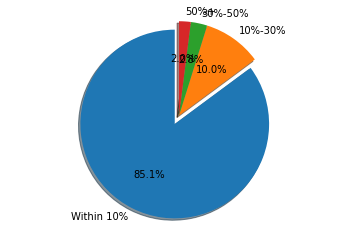

In [ ]:
#newdata = pd.DataFrame().reindex_like(amsmodel1)
#newdata.fillna(value=0, inplace=True)

# delete the variable to be predicted
#del newdata['house_price']
#newdata = newdata.iloc[[1]]

# insert information about your apartment 
#newdata['bedrooms'] = 1
#newdata['surface'] = 45
#newdata['yelp_prices'] = 2.234043
#newdata['yelp_ratings'] = 4.113475

# only change the number values in the postcode 
# and string values after the _ for the rental agency
#newdata["['p']_1018"]= 1
#newdata["['ag']_JLG Real Estate"] = 1

#for dataEnt in test_set:
#  price_label = dataEnt[0]
#  newdata = dataEnt[1:]
#  print(rf.predict(newdata))

#haHaa = rf.predict(datanp_demo[:,1:])
#lulset = datanp_demo[:,0]

haHaa = rf.predict(test_set[:,1:])
lulset = test_set_CP[:,0]

e_0 = 0
e_1 = 0
e_2 = 0
e_3 = 0

for i in range(len(haHaa)):
    #print("Prediction: ", haHaa[i])
    #print("Actual: ", lulset[i])
    if (abs(haHaa[i]-lulset[i]) <= lulset[i]*0.16):
      e_0 += 1
    elif (abs(haHaa[i]-lulset[i]) > lulset[i]*0.16 and abs(haHaa[i]-lulset[i]) <= lulset[i]*0.3):
      e_1 += 1
    elif (abs(haHaa[i]-lulset[i]) > lulset[i]*0.3 and abs(haHaa[i]-lulset[i]) <= lulset[i]*0.5):
      e_2 += 1
    else:
      e_3 += 1


labels = 'Within 10%', '10%-30%', '30%-50%', '50%+'
sizes = [e_0, e_1, e_2, e_3]
explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
np.savetxt("/content/drive/My Drive/Colab Notebooks/foo.csv", haHaa, delimiter=",")
np.savetxt("/content/drive/My Drive/Colab Notebooks/bar.csv", test_set_CP, delimiter=",")